<h1> Linear Regression For Classification </h1> <br>
<img src="../data/Linear_Regression.gif" width="1200" align="center">
Animation of our "model" at each step when training with gradient descent

<b>With our new knowledge of Python and Numpy, lets explore some linear models</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<h3> Loading the data </h3>
Lets load some "toy" data that we can use

In [2]:
# you can load your data using this cell
npzfile = np.load("../data/toy_data_two_moon.npz") # toy_data.npz or toy_data_two_circles.npz

#The compressed Numpy file is split up into 4 parts
#Train inputs and target outputs
#Test inputs and target outputs
X_train = npzfile['arr_0']
X_test = npzfile['arr_1']
y_train = npzfile['arr_2']
y_test = npzfile['arr_3']

# remember that each row in X_train and X_test is a sample. so X_train[1,:] is the first training sample

<h3> Let's plot our data </h3>

Text(0, 0.5, 'X1')

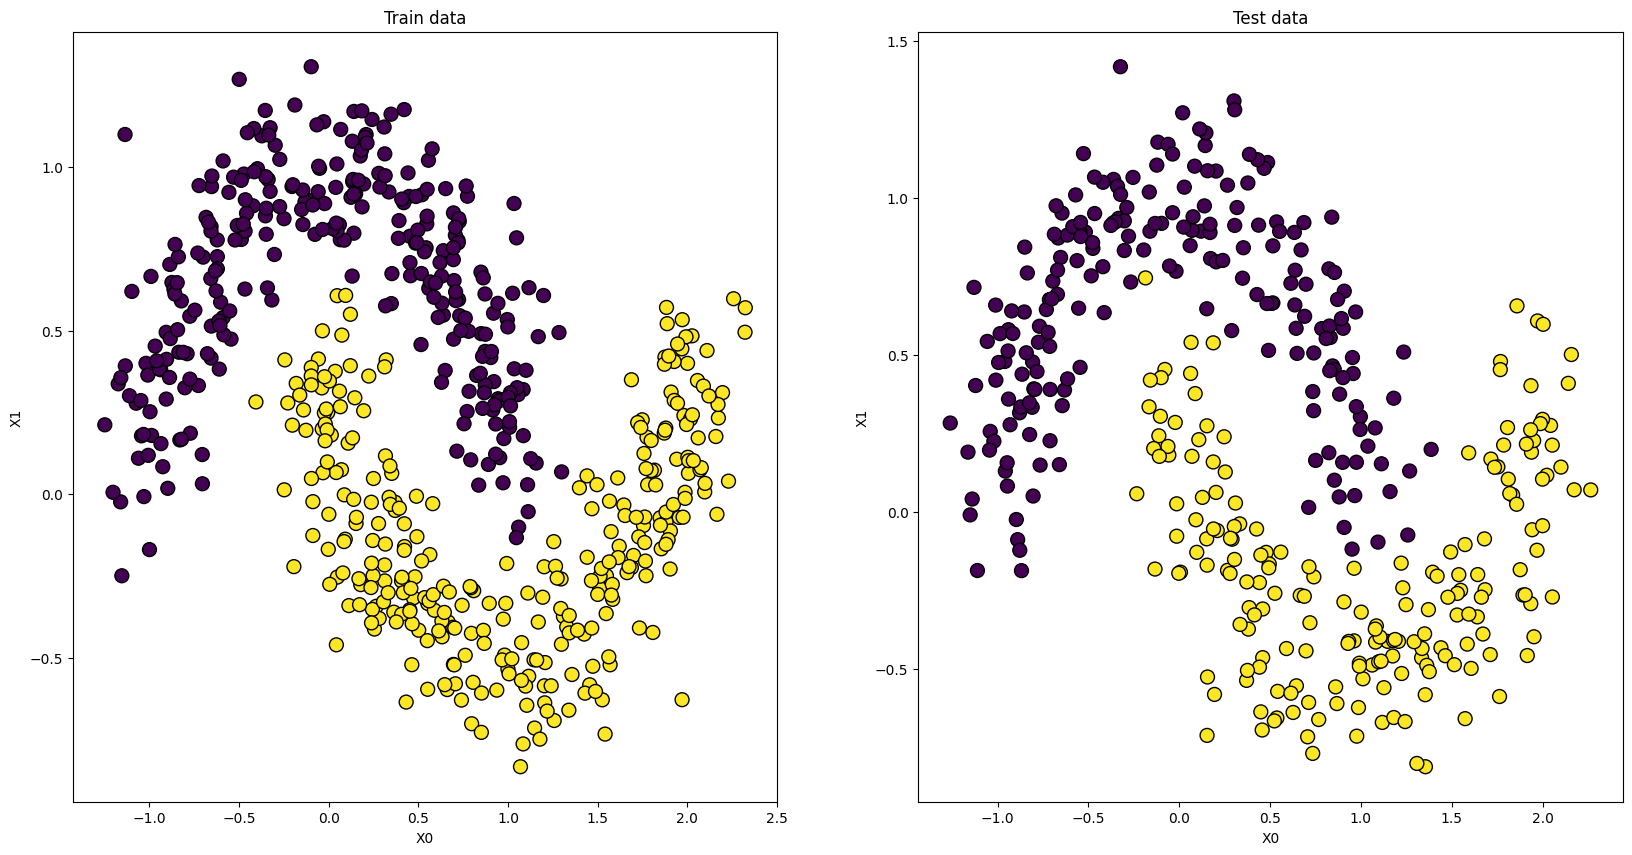

In [3]:
#Lets see what the data looks like
fig = plt.figure(figsize = (20, 10))
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train[:,0], s=100, edgecolor='k')
plt.title("Train data")
plt.xlabel("X0")
plt.ylabel("X1")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_test[:,0], s=100, edgecolor='k')
plt.title("Test data")
plt.xlabel("X0")
plt.ylabel("X1")

Our data is randomly sampled from an odd looking distribution, the colour of the dots (as represented by y_test[:,0], a one or zero) is what the output of our model SHOULD be (aka the "Ground Truth Data"). Note that each data point is a vector of two values (the "x and y" values), therefore there will only be two parameters in our linear model. <br>
In order to include a bias term let's augment the data by adding a "one" to every input datapoint. This gives us three values for every datapoint, the parameter associated with the constant "one" input is the bias term.


In [4]:
X_train_bias = np.c_[X_train,np.ones([y_train.size,1])]
X_test_bias = np.c_[X_test, np.ones([y_test.size,1])]

## Training a linear regression model in closed form
We recall that the parameters of a linear regression can be obtained in closed-form. If $\boldsymbol{X} \in \mathbb{R}^{m \times n}$ denotes the matrix of input data (each column is a training sample) and  $\boldsymbol{Y} \in \mathbb{R}^{m \times p}$ is the matrix of desired outputs, then the parameters of the model is obtained as
$\theta^\top = (\boldsymbol{X}^\top\boldsymbol{X})^{-1}\boldsymbol{X}^\top\boldsymbol{Y}$ .

To evaluate our model, we need the following function

In [5]:
#This function takes the model inputs and parameters and returns the outout of the model, rounded to 1 or 0
#AKA we threshold the output to 1 or 0 at 0.5
def predict(X, theta):
    return (np.matmul(X , theta) > 0.5).astype(int)

Now we can compute the values of $\theta$ using the closed form solution defined above

In [6]:
theta_lin = np.matmul(np.linalg.inv(np.matmul(X_train_bias.T,X_train_bias)),np.matmul(X_train_bias.T,y_train))
print("The values of Theta are:\n", theta_lin[:,0])

The values of Theta are:
 [ 0.1653395  -0.63670963  0.58245309]


In [7]:
y_test_hat_lin = predict(X_test_bias,theta_lin)
acc_lin = float(sum(y_test_hat_lin == y_test))/ float(len(y_test))
print("Accuracy of linear model(closed form): %.2f%% " %(acc_lin*100))

Accuracy of linear model(closed form): 88.25% 


Using the models predicted output labels (1/0) lets vislualise the result

Text(0.5, 1.0, 'Test data, linear model estimation')

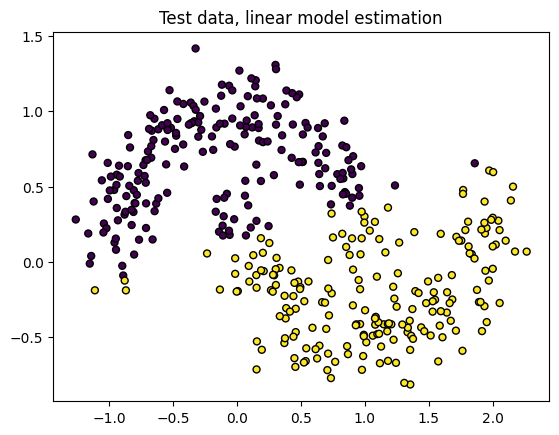

In [8]:
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_test_hat_lin[:,0], s=25, edgecolor='k')
plt.title("Test data, linear model estimation")

Because our data is 2D we can visualise our model as a line. We need to first transform it from the "general form" of the line equation: <br>
$0 = Ax + By + C$ <br>
To the more familiar form: <br>
$y = mx + C$ <br>
aka:
$y = -\frac{(Ax + C)}{B}$ <br>

In our case:<br>
$0.5 = \theta_0x + \theta_1y + \theta_2$ <br>
$y = -\frac{(\theta_0x + \theta_2 - 0.5)}{\theta_1}$ <br>

Note its 0.5 not 0 in our case due to where we thresholded the output, the line is therefore the "decision boundary" not stictly the line given by our model<br>


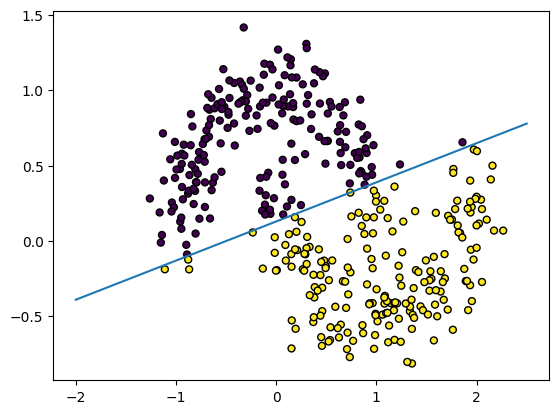

In [9]:
x_values = np.linspace(-2, 2.5, 100)
y_values = -((theta_lin[0,0])*x_values + theta_lin[2,0] - 0.5)/theta_lin[1,0]
plt.plot(x_values, y_values)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_test_hat_lin[:,0], s=25, edgecolor='k')

<h2>Training a model with Gradient Decent GD </h2>

[Gradient Descent, Step-by-Step by StatQuest](https://youtu.be/sDv4f4s2SB8?si=iClqYh2v3I7uf9WR)

To do so, we need a function to <br>
1- compute the loss with respect to the inputs and the parameters of the model <br>
2- compute the gradient of the model with respect to its parameters $\theta$

The loss of the linear regression as
\begin{align}
L(\theta) = \frac{1}{m} \sum_{i=1}^m \|\theta^\top \boldsymbol{x}_i - y_i\|^2
\end{align}

Now it is easy to see that

\begin{align}
\frac{\partial L}{\partial \theta} = \frac{1}{m} \sum_{i=1}^m 2(\theta^\top \boldsymbol{x}_i - y_i)\boldsymbol{x}_i
\end{align}

The function below implements this for us.

In [10]:
def compute_grad_loss(X, y, theta):
    #this function will get X, a set of samples (each sample is a row in X),
    #the corresponding labels in the array y and the current parameter of the regression model theta
    
    h = np.matmul(X , theta)

    loss = np.mean((h - y)**2)
    grad_vec = np.matmul(X.T , (h - y))/y.shape[0]
    return loss, grad_vec

With this, we can perform multiple itteration of GD to train the model

In [11]:
# theta is the parameters of the linear model
# To learn them, we randomly initialize them below
theta = np.random.randn(X_test_bias.shape[1],1)
lr = 0.5

#number of times we iterate over the dataset
max_epoch = 50 

loss = [] #keep track of the loss values
acc = [] #keep track of the accuracy 
for epoch in range(max_epoch):
    y_test_hat = predict(X_test_bias,theta)

    acc.append(float(sum(y_test_hat == y_test))/ float(len(y_test)))

    # call the compute_grad_loss that is implemented above to 
    # measure the loss and the gradient
    tmpLoss, grad_vec = compute_grad_loss(X_train_bias, y_train, theta)
    loss.append(tmpLoss)
    #update the theta parameter according to the GD here
    theta -= lr*grad_vec 
    
print("Accuracy of linear model(GD): %.2f%% " %(acc[-1]*100))
print("The values of Theta are:\n", theta[:,0])

Accuracy of linear model(GD): 88.50% 
The values of Theta are:
 [ 0.17240811 -0.61762811  0.57232452]


Text(0.5, 1.0, 'Model accuracy per iteration')

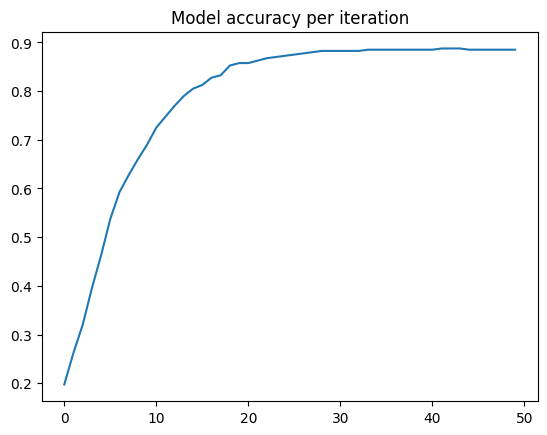

In [12]:
plt.plot(acc)
plt.title("Model accuracy per iteration")